# hit-song-classifier

## Multilayer Perceptron

The first thing we'll do is define our imports and declare any constants.


In [1]:
# Define our imports
import numpy as np
import matplotlib.pyplot as plt
import os

from pyspark.sql import DataFrame, SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import ConfusionMatrixDisplay

# Allocate enough memory for our Spark session
memory = "8g"
pyspark_submit_args = f"--driver-memory {memory} pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

# Define our constants
TARGET_DATA = "../../data/spotify_enhanced_dataset.csv"
RANDOM_SEED = 0
TARGET_FEATURES = [
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

Next, we shall split our data in a 60-20-20 train_test_val split. Then we shall build our set of inputs X. We don't want to include the features `[song, artist, year]` since they are keys. We also should define our label `class` since that is our classification feature.

In [2]:
def feature_transformer(df: DataFrame) -> DataFrame:
    """Assembles feature vectors and scales them in dataframe

    Args:
        df (DataFrame): input

    Returns:
        DataFrame: feature-label dataframe
    """
    va = VectorAssembler(inputCols=TARGET_FEATURES, outputCol="features")
    ss = StandardScaler(inputCol="features", outputCol="scaled_features")
    va_df = va.transform(df)
    ss_df = ss.fit(va_df).transform(va_df)
    return ss_df


def load_data(filename: str) -> DataFrame:
    """Load data from file

    Args:
        filename (str): filename

    Returns:
        DataFrame: pyspark dataframe
    """
    spark = SparkSession.builder.appName("hit-song-classifier-rfc").getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    return spark.read.csv(filename, header=True, inferSchema=True, quote='"')


def split_data(df: DataFrame) -> tuple[DataFrame, DataFrame, DataFrame]:
    """Splits data to train, val, test splits

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    train, val, test = df.randomSplit([0.6, 0.2, 0.2], seed=RANDOM_SEED)
    return train, val, test


df = feature_transformer(load_data(TARGET_DATA))
train_df, val_df, test_df = split_data(df)
print(f"Train: {train_df.count()}\nTest: {test_df.count()}\nVal: {val_df.count()}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/10 15:20:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Train: 19520
Test: 6531
Val: 6458


## Hyperparameter search: training multiple estimators

Here we will train multiple estimators with different hyperparameter settings. For MultilayerPerceptronClassifier, the hyperparameters we've chosen include `layers` and `maxIter`.

In [3]:
def train_estimators(
    data: DataFrame,
    estimator_type: any,
    param_name: str,
    param_vals: list,
    **kwargs,
) -> list:
    """Trains estimators

    Args:
        data (DataFrame): dataframe
        estimator_type (MultilayerPerceptronClassifier): estimator
        param_name (str): parameter name
        param_vals (list): parameter values

    Returns:
        list: list of trained estimators
    """
    estimators = []
    for val in param_vals:
        estimator = estimator_type(**{param_name: val}, **kwargs)
        fitted_models = estimator.fit(data)
        estimators.append(fitted_models)
        print(f"Training {fitted_models}")
    return estimators

### Hyperparameter search: `hidden layers`




In [4]:
input_size = len(TARGET_FEATURES)
output_size = len(df.select("class").distinct().collect())
mid_layers = [1, 5, 10, 20, 50, 100]
hidden_layers = [[input_size, mid, output_size] for mid in mid_layers]

mlp_depth = train_estimators(
    train_df,
    MultilayerPerceptronClassifier,
    "layers",
    hidden_layers,
    featuresCol="scaled_features",
    labelCol="class",
    seed=RANDOM_SEED,
)

Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_4bce095d338c, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_23a8fd70f5ed, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_aa52073ae86b, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_e6ce1bfede94, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_7af0c63e30d4, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_24aaf931b3dd, numLayers=3, numClasses=11, numFeatures=14


We want to plot estimator scores to pick the estimator with the best score.

In [5]:
def score_model(models: list, data: DataFrame) -> list:
    """Scores models

    Args:
        estimators (list): list of estimators
        data (DataFrame): dataframe

    Returns:
        list: list of scores
    """
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    predicted = [model.transform(data) for model in models]
    return [evaluator.evaluate(pred) for pred in predicted]


print(f"train: {score_model(mlp_depth, train_df)}")
print(f"val: {score_model(mlp_depth, val_df)}")
print(f"test: {score_model(mlp_depth, test_df)}")

train: [0.04102367943734019, 0.12934998285844568, 0.12060098942352077, 0.1353719131779476, 0.15358520765011718, 0.14741491881237245]
val: [0.041447542767446326, 0.12954712540298638, 0.11661266152026555, 0.1406157881982629, 0.15166944095859383, 0.14044832463550758]
test: [0.041043231350336024, 0.12176620900113565, 0.11369901657851972, 0.13159239859434121, 0.14048253713316064, 0.1324597796879169]


### Hyperparameter search: `maxIter`


In [6]:
feat_count = len(TARGET_FEATURES)
class_count = len(df.select("class").distinct().collect())
max_iter = [1, 5, 10, 20, 50, 100]
mlp_iter = train_estimators(
    train_df,
    MultilayerPerceptronClassifier,
    "maxIter",
    max_iter,
    featuresCol="scaled_features",
    labelCol="class",
    layers=[feat_count, 20, 20, class_count],
    seed=RANDOM_SEED,
)

Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_51ce515cc6e6, numLayers=4, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_d92b68af7d62, numLayers=4, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_15f2bb0e31c9, numLayers=4, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_adb9266dfbe8, numLayers=4, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_28e006cd9b21, numLayers=4, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_e8f87055109e, numLayers=4, numClasses=11, numFeatures=14


### Evaluate the F1 score of the hyperparameters for `layers` and `maxIter`

In [7]:
print(f"train: {score_model(mlp_iter, train_df)}")
print(f"val: {score_model(mlp_iter, val_df)}")
print(f"test: {score_model(mlp_iter, test_df)}")

train: [0.04102550093096586, 0.04204683491474909, 0.047421142065494824, 0.08481440823672878, 0.1092327714695262, 0.14047182645207684]
val: [0.041447542767446326, 0.04178035042868987, 0.04635647928752909, 0.08292295729908324, 0.10502862951833067, 0.13932419615997374]
test: [0.04104867836179592, 0.04199758017118374, 0.04578779214228369, 0.08456753331254495, 0.10432122752643282, 0.1353281099310907]


In [8]:
def plot_estimator_scores(models: list, param_name: str, param_vals: list[int]):
    """Plots the scores of a list of estimators"""

    train_score = score_model(models, train_df)
    val_score = score_model(models, val_df)
    test_score = score_model(models, test_df)

    # Get the best validation score and the index of the best estimator
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Plot metrics
    plt.figure()
    plt.plot(np.arange(len(train_score)), train_score, "go-", label="train")
    plt.plot(np.arange(len(val_score)), val_score, "ro-", label="val")
    plt.plot(np.arange(len(test_score)), test_score, "k:", label="test")
    # Place an X at the best validation score
    plt.scatter(best_val_idx, best_val_score, marker="x", color="r", s=200)

    # Additional formatting
    plt.ylim(0, 1.05)
    plt.xticks(ticks=np.arange(len(train_score)), labels=param_vals, rotation=45)
    plt.ylabel("score")
    plt.xlabel(param_name)
    plt.title(f"{models[0].__class__.__name__} score vs. {param_name}")

    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.3,
        f"train = {train_score[best_val_idx]:.3f}",
        c="g",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.2,
        f"validate = {best_val_score:.3f}",
        c="r",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.1,
        f"test = {test_score[best_val_idx]:.3f}",
        c="k",
        ha="right",
    )
    plt.legend()

CPU times: user 159 ms, sys: 43.7 ms, total: 203 ms
Wall time: 5.43 s


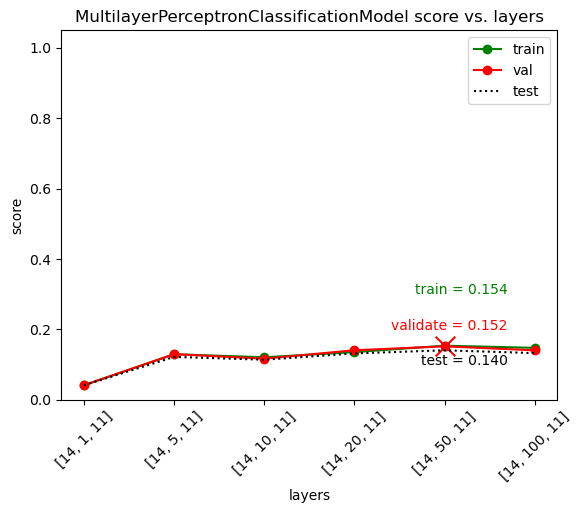

In [9]:
%%time
plot_estimator_scores(mlp_depth, "layers", hidden_layers)

CPU times: user 218 ms, sys: 52.5 ms, total: 271 ms
Wall time: 5.61 s


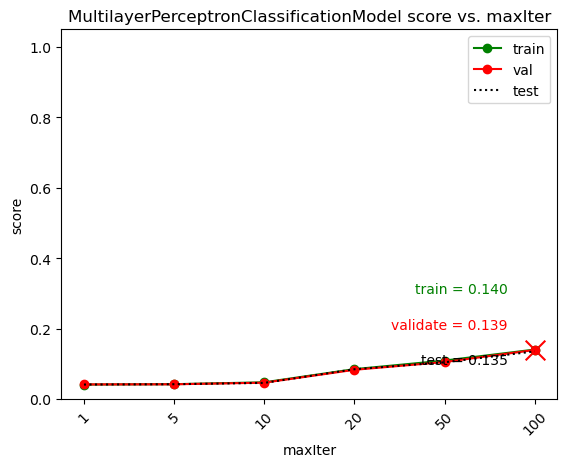

In [10]:
%%time
plot_estimator_scores(mlp_iter, "maxIter", max_iter)

## Evaluation using Confusion Matrices

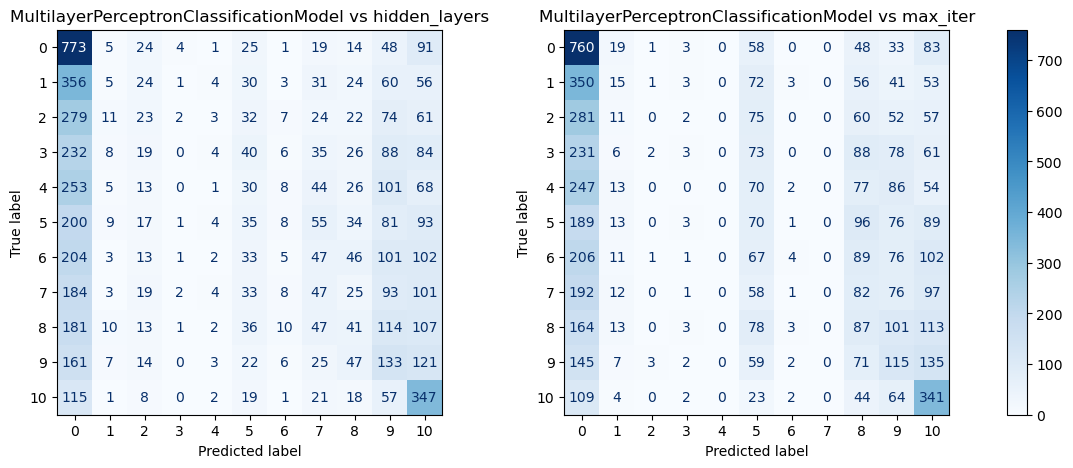

In [15]:
# Declare models and model names
model_list = [mlp_depth, mlp_iter]
model_names = ["hidden_layers", "max_iter"]


def generate_confusion_matrix(model_list: list, val_df: DataFrame, test_df: DataFrame):
    """Generates a confusion matrix for each model in model_list"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, model in enumerate(model_list):
        val_score = score_model(model, val_df)
        best_val_score = max(val_score)
        best_val_idx = val_score.index(best_val_score)

        # Generate confusion matrix
        best_model = (
            model[best_val_idx].transform(test_df).select("class", "prediction")
        )
        predictionAndLabels = best_model.rdd.map(
            lambda row: (float(row["prediction"]), float(row["class"]))
        )
        class_names = (
            best_model.select("class")
            .distinct()
            .sort("class")
            .rdd.map(lambda row: row[0])
            .collect()
        )
        metrics = MulticlassMetrics(predictionAndLabels)
        con_mtrx = metrics.confusionMatrix().toArray().astype(int)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(
            confusion_matrix=con_mtrx, display_labels=class_names
        )
        disp.plot(ax=axes[i], colorbar=False, cmap="Blues")
        axes[i % 2].set_title(f"{model[best_val_idx].__class__.__name__} vs {model_names[i % 2]}")

    # Add colorbar
    fig.colorbar(disp.im_, ax=axes.ravel().tolist())


generate_confusion_matrix(model_list, val_df, test_df)

## Putting it all together using Cross-Validation

Since we evaluated the hyperparameters separately above, we should create a Pipeline in which the best hyperparameters are determined grid-wise. This should automate what we did above.

In [12]:
def cross_validator(train_data: DataFrame) -> CrossValidatorModel:
    """Performs cross validation"""

    # Define the estimator
    mlp = MultilayerPerceptronClassifier(
        featuresCol="scaled_features",
        labelCol="class",
        seed=RANDOM_SEED,
    )

    # Define the parameter grid
    param_grid = (
        ParamGridBuilder()
        .addGrid(mlp.layers, hidden_layers)
        .addGrid(mlp.maxIter, max_iter)
        .build()
    )

    # Define the evaluator using F1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    # Create the cross validator with 5 folds
    cv = CrossValidator(
        estimator=mlp, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3
    )
    cv_model = cv.fit(train_data)

    return cv_model


cv_model = cross_validator(train_df)

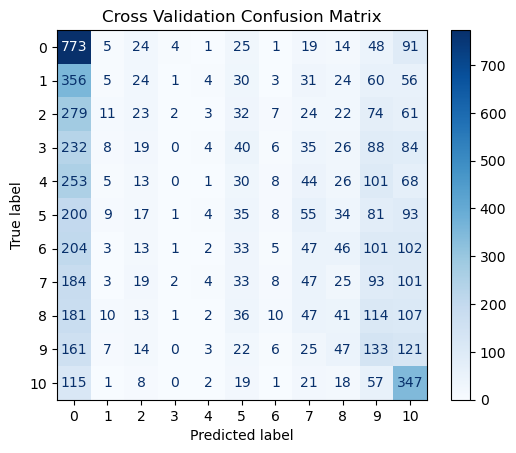

In [13]:
def generate_cross_val_confusion_matrix(
    cv_model: CrossValidatorModel, test_df: DataFrame
):
    """Generates a confusion matrix for the best model from cross validation"""

    # Generate confusion matrix
    predictionAndLabels = (
        cv_model.transform(test_df)
        .select("class", "prediction")
        .rdd.map(lambda row: (float(row["prediction"]), float(row["class"])))
    )
    class_names = (
        test_df.select("class")
        .distinct()
        .sort("class")
        .rdd.map(lambda row: row[0])
        .collect()
    )
    metrics = MulticlassMetrics(predictionAndLabels)
    con_mtrx = metrics.confusionMatrix().toArray().astype(int)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=con_mtrx, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Cross Validation Confusion Matrix")


generate_cross_val_confusion_matrix(cv_model, test_df)

### Explaining best hyperparameters

Now we should explain the best hyperparameters for the cross-validation model.


In [14]:
print(cv_model.bestModel.explainParam("layers"))
print(cv_model.bestModel.explainParam("maxIter"))

layers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [14, 50, 11])
maxIter: max number of iterations (>= 0). (default: 100, current: 100)
